# 02 - Scraping Song Lyrics
This notebook contains code for obtaining lyrics for each of Billboard's Hot 100 singles from 1960 to 2017.

In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import warnings
import re
import html
import unidecode

from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

Below is the CSV created from **01 - Scraping Billboard Charts** containing Year-end Hot 100 Singles data.

In [2]:
billboard = pd.read_csv('../data/billboard.csv')
billboard.sample(5)

,index,artist_all,artist_base,rank,song,year,artist_featured
646,46,johnny rivers,johnny rivers,47,secret agent man,1966,NaN
1623,22,nazareth,nazareth,23,love hurts,1976,NaN
469,69,joe hinton,joe hinton,70,funny how time slips away,1964,NaN
2613,12,gloria loring and carl anderson,gloria loring,13,friends and lovers,1986,NaN
1997,96,diana ross,diana ross,97,the boss,1979,NaN


## Additional data cleaning
A few additional cleaning steps need to be made to the **artist_base** and **song** fields to help with querying for data. For artists, we replace the ampersand **&** with **and**, and for both artists and songs, we strip the text of accents, replace hyphens **-** with spaces, and remove all other punctuation.

In [3]:
def clean_song(x):
    x = x.replace('-', ' ')
    x = re.sub(r'[^\w\s]','', x)
    x = unidecode.unidecode(x)
    return x

billboard[['artist_base']]\
    = billboard[['artist_base']].applymap(
        lambda x: x.replace('&', 'and'))

billboard[['song_clean', 'artist_clean']]\
    = billboard[['song', 'artist_base']].applymap(clean_song)

billboard.sample(5)

,index,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean
5507,6,taylor swift,taylor swift,7,blank space,2015,NaN,blank space,taylor swift
1895,94,eruption,eruption,95,i can't stand the rain,1978,NaN,i cant stand the rain,eruption
154,54,bob moore,bob moore,55,mexico,1961,NaN,mexico,bob moore
1275,74,alice cooper,alice cooper,75,school's out,1972,NaN,schools out,alice cooper
4909,8,kanye west,kanye west,9,heartless,2009,NaN,heartless,kanye west


## Obtaining lyrics
There exist many API's for accessing song lyrics, but many require a fee, and those that do not tend to be unstable or not include a sufficiently comprehensive database of songs. Instead, we scrape from four websites' URL's directly. For each website, a page of lyrics can be obtained through some modified URL comprising of the song and artist names. The websites are scraped sequentially in the following order until a successful scrape has occurred or all URL's have been tried:

1. [www.genius.com](www.genius.com)
2. [www.songlyrics.com](www.songlyrics.com)
3. [www.lyricsmode.com](www.lyricsmode.com)
4. [www.metrolyrics.com](www.metrolyrics.com)

Many bands have names beginning with _The_, which no website handles consistently; sometimes the article is included in the url, other times it is omitted. For this reason, if an artist with _The_ in its name fails the first round of queries, the same name with _The_ removed is used for a second round.

In [62]:
lyrics_list = list() # collector for lyric strings or None if no lyrics found
source_list = list() # collector for the URL from which lyrics were obtained

for index, row in billboard.iterrows():
    artist = row['artist_clean']
    artist_2 = re.sub(r'^the ', '', row['artist_clean']) # if initial round fails
    song = row['song_clean']
    source = None
    
    # generate URLs for each website. some uses dashes in place of 
    # whitespaces, others use underscores
    urls = list()
    metro_url = 'http://metrolyrics.com/{}-lyrics-{}.html'.format(
        song.replace(' ', '-'), artist.replace(' ', '-'))
    song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    mode_url = 'http://www.lyricsmode.com/lyrics/{}/{}/{}.html'.format(
        artist[0], artist.replace(' ', '_'), song.replace(' ', '_'))
    genius_url = 'https://genius.com/{}-{}-lyrics'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    urls.extend([genius_url, song_url, mode_url, metro_url])
    if artist != artist_2:
        genius_url = 'https://genius.com/{}-{}-lyrics'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        metro_url = 'http://metrolyrics.com/{}-lyrics-{}.html'.format(
                song.replace(' ', '-'), artist_2.replace(' ', '-'))
        song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        mode_url = 'http://www.lyricsmode.com/lyrics/{}/{}/{}.html'.format(
            artist_2[0], artist_2.replace(' ', '_'), song.replace(' ', '_'))
        urls.extend([genius_url, song_url, mode_url, metro_url])
    
    # attempt scrape and parse sequence. lyrics collected as list of tokens.
    for url in urls:
        try:
            # request HTML and parse
            html = requests.get(url=url).content
            soup = bs4.BeautifulSoup(html)
            
            # find lyrics and pre-process
            if 'genius.com' in url:
                print(url)
                lyrics = soup\
                    .find('div', {'class': 'lyrics'})\
                    .find('p')\
                    .findAll(text=True)
                if lyrics is None:
                    raise Exception
                source = 'genius.com'
                
            # for songlyrics.com, if no lyrics found, a message is displayed
            # where lyrics would be. thus, we check for this message instead.
            if 'songlyrics' in url:
                print(url)
                lyrics = soup\
                    .find('p', {'id': 'songLyricsDiv'})\
                    .findAll(text=True)
                if 'Sorry, we have no ' in lyrics[0]:
                    lyrics = None
                    raise Exception
                source = 'songlyrics.com'
            if 'lyricsmode' in url:
                print(url)
                lyrics = soup.find('p', {'id': 'lyrics_text'})
                if lyrics is None:
                    raise Exception
                lyrics = lyrics.text.split()
                source = 'lyricsmode.com'
            if 'metrolyrics' in url:
                print(url)
                lyrics = soup.find('div', {'id': 'lyrics-body-text'})
                if lyrics is None:
                    raise Exception
                lyrics = [line.findAll(text=True)\
                          for line in soup.findAll('p', {'class': 'verse'})]
                lyrics = [item for sublist in lyrics for item in sublist]
                source = 'metrolyrics.com'
            
#             # pre-processing below only occurs if query successful
#             lyrics = ' '.join(lyrics).lower().replace('\n', '')
            
#             # remove apostrophes
#             lyrics = lyrics.replace('\'', '')
            
#             # remove song structure tags in square brackets
#             lyrics = re.sub(r'\[.*\]' , ' ', lyrics)
            
#             # all other punctuations replaced with spaces
#             lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
#             # replace consecutive whitespaces with single space
#             lyrics = re.sub(r'\s+', ' ', lyrics)
            
            break
        except:
            print('error')
    lyrics_list.append(lyrics)
    source_list.append(source)

https://genius.com/percy-faith-theme-from-a-summer-place-lyrics
https://genius.com/jim-reeves-hell-have-to-go-lyrics
error
http://songlyrics.com/jim-reeves/hell-have-to-go-lyrics/
https://genius.com/the-everly-brothers-cathys-clown-lyrics
https://genius.com/johnny-preston-running-bear-lyrics
https://genius.com/mark-dinning-teen-angel-lyrics
https://genius.com/brenda-lee-im-sorry-lyrics
https://genius.com/elvis-presley-its-now-or-never-lyrics
https://genius.com/jimmy-jones-handy-man-lyrics
error
http://songlyrics.com/jimmy-jones/handy-man-lyrics/
https://genius.com/elvis-presley-stuck-on-you-lyrics
https://genius.com/chubby-checker-the-twist-lyrics
https://genius.com/connie-francis-everybodys-somebodys-fool-lyrics
https://genius.com/bobby-rydell-wild-one-lyrics
https://genius.com/the-brothers-four-greenfields-lyrics
https://genius.com/jack-scott-what-in-the-worlds-come-over-you-lyrics
https://genius.com/marty-robbins-el-paso-lyrics
https://genius.com/the-hollywood-argyles-alley-oop-lyri

https://genius.com/sue-thompson-sad-movies-make-me-cry-lyrics
https://genius.com/ernie-k-doe-mother-in-law-lyrics
https://genius.com/the-dovells-bristol-stomp-lyrics
https://genius.com/ricky-nelson-travelin-man-lyrics
https://genius.com/the-miracles-shop-around-lyrics
https://genius.com/brook-benton-the-boll-weevil-song-lyrics
https://genius.com/gene-mcdaniels-a-hundred-pounds-of-clay-lyrics
https://genius.com/dick-and-deedee-the-mountains-high-lyrics
error
http://songlyrics.com/dick-and-deedee/the-mountains-high-lyrics/
https://genius.com/marty-robbins-dont-worry-lyrics
https://genius.com/floyd-cramer-on-the-rebound-lyrics
https://genius.com/steve-lawrence-portrait-of-my-love-lyrics
error
http://songlyrics.com/steve-lawrence/portrait-of-my-love-lyrics/
https://genius.com/gary-us-bonds-quarter-to-three-lyrics
https://genius.com/barry-mann-who-put-the-bomp-in-the-bomp-bomp-bomp-lyrics
https://genius.com/neil-sedaka-calendar-girl-lyrics
https://genius.com/chris-kenner-i-like-it-like-that

https://genius.com/ace-cannon-tuff-lyrics
https://genius.com/clyde-mcphatter-lover-please-lyrics
https://genius.com/barbara-george-i-know-you-dont-love-me-no-more-lyrics
https://genius.com/ricky-nelson-young-world-lyrics
https://genius.com/the-shirelles-baby-its-you-lyrics
https://genius.com/pat-boone-speedy-gonzales-lyrics
https://genius.com/burl-ives-a-little-bitty-tear-lyrics
https://genius.com/the-everly-brothers-crying-in-the-rain-lyrics
https://genius.com/emilio-pericoli-al-di-la-lyrics
https://genius.com/ernie-maresca-shout-shout-knock-yourself-out-lyrics
https://genius.com/don-and-juan-whats-your-name-lyrics
https://genius.com/the-corsairs-smoky-places-lyrics
error
http://songlyrics.com/the-corsairs/smoky-places-lyrics/
https://genius.com/sam-cooke-having-a-party-lyrics
https://genius.com/booker-t-and-the-mgs-green-onions-lyrics
https://genius.com/ray-charles-you-dont-know-me-lyrics
https://genius.com/the-four-seasons-sherry-lyrics
https://genius.com/joanie-sommers-johnny-get-a

https://genius.com/nino-tempo-and-april-stevens-deep-purple-lyrics
https://genius.com/ned-miller-from-a-jack-to-a-king-lyrics
https://genius.com/the-drifters-up-on-the-roof-lyrics
https://genius.com/johnny-mathis-what-will-my-mary-say-lyrics
https://genius.com/jan-bradley-mama-didnt-lie-lyrics
https://genius.com/bobby-vee-the-night-has-a-thousand-eyes-lyrics
https://genius.com/the-cookies-dont-say-nothin-bad-about-my-baby-lyrics
https://genius.com/johnny-cash-ring-of-fire-lyrics
https://genius.com/doris-troy-just-one-look-lyrics
https://genius.com/allan-sherman-hello-muddah-hello-fadduh-lyrics
https://genius.com/lesley-gore-judys-turn-to-cry-lyrics
https://genius.com/rolf-harris-tie-me-kangaroo-down-sport-lyrics
https://genius.com/ricky-nelson-fools-rush-in-lyrics
error
http://songlyrics.com/ricky-nelson/fools-rush-in-lyrics/
https://genius.com/the-village-stompers-washington-square-lyrics
https://genius.com/dion-donna-the-prima-donna-lyrics
https://genius.com/nat-king-cole-that-sunday

https://genius.com/the-jelly-beans-i-wanna-love-him-so-bad-lyrics
https://genius.com/roger-miller-dang-me-lyrics
https://genius.com/al-hirt-cotton-candy-lyrics
error
http://songlyrics.com/al-hirt/cotton-candy-lyrics/
https://genius.com/nancy-wilson-you-dont-know-how-glad-i-am-lyrics
https://genius.com/the-kingsmen-money-thats-what-i-want-lyrics
https://genius.com/the-searchers-dont-throw-your-love-away-lyrics
https://genius.com/tommy-tucker-hi-heel-sneakers-lyrics
https://genius.com/gerry-and-the-pacemakers-how-do-you-do-it-lyrics
https://genius.com/the-ventures-walk-dont-run-lyrics
https://genius.com/the-dave-clark-five-do-you-love-me-lyrics
https://genius.com/robert-maxwell-shangri-la-lyrics
error
http://songlyrics.com/robert-maxwell/shangri-la-lyrics/
https://genius.com/jumpin-gene-simmons-haunted-house-lyrics
https://genius.com/jimmy-hughes-steal-away-lyrics
https://genius.com/the-beatles-i-saw-her-standing-there-lyrics
https://genius.com/andy-williams-a-fool-never-learns-lyrics
ht

https://genius.com/marvin-gaye-how-sweet-it-is-to-be-loved-by-you-lyrics
https://genius.com/the-mamas-and-the-papas-california-dreamin-lyrics
https://genius.com/-and-the-mysterians-96-tears-lyrics
error
http://songlyrics.com/-and-the-mysterians/96-tears-lyrics/
https://genius.com/jimmy-ruffin-what-becomes-of-the-brokenhearted-lyrics
https://genius.com/the-monkees-last-train-to-clarksville-lyrics
error
http://songlyrics.com/the-monkees/last-train-to-clarksville-lyrics/
https://genius.com/four-tops-reach-out-ill-be-there-lyrics
https://genius.com/nancy-sinatra-these-boots-are-made-for-walkin-lyrics
https://genius.com/the-association-cherish-lyrics
https://genius.com/frank-sinatra-strangers-in-the-night-lyrics
https://genius.com/paul-revere-and-the-raiders-kicks-lyrics
https://genius.com/barry-sadler-ballad-of-the-green-berets-lyrics
https://genius.com/the-rascals-good-lovin-lyrics
https://genius.com/the-righteous-brothers-youre-my-soul-and-inspiration-lyrics
https://genius.com/the-suprem

https://genius.com/the-turtles-happy-together-lyrics
https://genius.com/the-rascals-groovin-lyrics
error
http://songlyrics.com/the-rascals/groovin-lyrics/
https://genius.com/frankie-valli-cant-take-my-eyes-off-you-lyrics
https://genius.com/the-music-explosion-little-bit-o-soul-lyrics
error
http://songlyrics.com/the-music-explosion/little-bit-o-soul-lyrics/
https://genius.com/tommy-james-and-the-shondells-i-think-were-alone-now-lyrics
https://genius.com/aretha-franklin-respect-lyrics
https://genius.com/stevie-wonder-i-was-made-to-love-her-lyrics
https://genius.com/bobby-vee-come-back-when-you-grow-up-lyrics
https://genius.com/the-buckinghams-kind-of-a-drag-lyrics
https://genius.com/arthur-conley-sweet-soul-music-lyrics
https://genius.com/the-soul-survivors-expressway-to-your-heart-lyrics
https://genius.com/sam-and-dave-soul-man-lyrics
https://genius.com/the-association-never-my-love-lyrics
https://genius.com/jay-and-the-techniques-apples-peaches-pumpkin-pie-lyrics
https://genius.com/eve

https://genius.com/classics-iv-spooky-lyrics
https://genius.com/the-supremes-love-child-lyrics
https://genius.com/merrilee-rush-angel-of-the-morning-lyrics
https://genius.com/georgie-fame-the-ballad-of-bonnie-and-clyde-lyrics
https://genius.com/mary-hopkin-those-were-the-days-lyrics
https://genius.com/steppenwolf-born-to-be-wild-lyrics
https://genius.com/the-intruders-cowboys-to-girls-lyrics
error
http://songlyrics.com/the-intruders/cowboys-to-girls-lyrics/
https://genius.com/1910-fruitgum-company-simon-says-lyrics
https://genius.com/gary-puckett-and-the-union-gap-lady-willpower-lyrics
https://genius.com/the-rascals-a-beautiful-morning-lyrics
error
http://songlyrics.com/the-rascals/a-beautiful-morning-lyrics/
https://genius.com/sergio-mendes-the-look-of-love-lyrics
https://genius.com/johnny-nash-hold-me-tight-lyrics
https://genius.com/ohio-express-yummy-yummy-yummy-lyrics
https://genius.com/the-crazy-world-of-arthur-brown-fire-lyrics
https://genius.com/the-troggs-love-is-all-around-lyr

https://genius.com/the-guess-who-these-eyes-lyrics
https://genius.com/blood-sweat-and-tears-youve-made-me-so-very-happy-lyrics
https://genius.com/jackie-deshannon-put-a-little-love-in-your-heart-lyrics
https://genius.com/charles-wright-and-the-watts-103rd-street-rhythm-band-do-your-thing-lyrics
https://genius.com/the-grass-roots-id-wait-a-million-years-lyrics
error
http://songlyrics.com/the-grass-roots/id-wait-a-million-years-lyrics/
https://genius.com/the-doors-touch-me-lyrics
https://genius.com/spiral-starecase-more-today-than-yesterday-lyrics
https://genius.com/sammy-davis-jr-ive-gotta-be-me-lyrics
https://genius.com/bob-dylan-lay-lady-lay-lyrics
https://genius.com/donovan-atlantis-lyrics
https://genius.com/classics-iv-traces-lyrics
https://genius.com/cass-elliot-its-getting-better-lyrics
https://genius.com/jay-and-the-americans-this-magic-moment-lyrics
https://genius.com/the-temptations-runaway-child-running-wild-lyrics
error
http://songlyrics.com/the-temptations/runaway-child-runn

http://songlyrics.com/frijid-pink/the-house-of-the-rising-sun-lyrics/
https://genius.com/chicago-25-or-6-to-4-lyrics
https://genius.com/white-plains-my-baby-loves-lovin-lyrics
https://genius.com/the-friends-of-distinction-love-or-let-me-be-lonely-lyrics
https://genius.com/the-brotherhood-of-man-united-we-stand-lyrics
error
http://songlyrics.com/the-brotherhood-of-man/united-we-stand-lyrics/
https://genius.com/the-carpenters-weve-only-just-begun-lyrics
https://genius.com/mark-lindsay-arizona-lyrics
https://genius.com/james-taylor-fire-and-rain-lyrics
https://genius.com/gene-chandler-groovy-situation-lyrics
https://genius.com/santana-evil-ways-lyrics
https://genius.com/the-guess-who-no-time-lyrics
https://genius.com/the-delfonics-didnt-i-blow-your-mind-this-time-lyrics
https://genius.com/elvis-presley-the-wonder-of-you-lyrics
https://genius.com/creedence-clearwater-revival-up-around-the-bend-lyrics
https://genius.com/ronnie-dyson-if-you-let-me-make-love-to-you-then-why-cant-i-touch-you-l

https://genius.com/bee-gees-lonely-days-lyrics
https://genius.com/the-fortunes-here-comes-that-rainy-day-feeling-again-lyrics
https://genius.com/the-who-wont-get-fooled-again-lyrics
https://genius.com/denise-lasalle-trapped-by-a-thing-called-love-lyrics
https://genius.com/the-jackson-5-mamas-pearl-lyrics
https://genius.com/the-buoys-timothy-lyrics
https://genius.com/the-partridge-family-i-woke-up-in-love-this-morning-lyrics
https://genius.com/isaac-hayes-theme-from-shaft-lyrics
https://genius.com/gladys-knight-and-the-pips-if-i-were-your-woman-lyrics
https://genius.com/neil-diamond-i-am-i-said-lyrics
https://genius.com/paul-stookey-the-wedding-song-there-is-love-lyrics
error
http://songlyrics.com/paul-stookey/the-wedding-song-there-is-love-lyrics/
https://genius.com/wilson-pickett-dont-knock-my-love-part-1-lyrics
https://genius.com/the-doors-love-her-madly-lyrics
https://genius.com/richie-havens-here-comes-the-sun-lyrics
https://genius.com/wadsworth-mansion-sweet-mary-lyrics
https://ge

https://genius.com/carly-simon-youre-so-vain-lyrics
https://genius.com/diana-ross-touch-me-in-the-morning-lyrics
https://genius.com/vicki-lawrence-the-night-the-lights-went-out-in-georgia-lyrics
https://genius.com/clint-holmes-playground-in-my-mind-lyrics
https://genius.com/stories-brother-louie-lyrics
error
http://songlyrics.com/stories/brother-louie-lyrics/
https://genius.com/helen-reddy-delta-dawn-lyrics
https://genius.com/billy-paul-me-and-mrs-jones-lyrics
https://genius.com/edgar-winter-frankenstein-lyrics
error
http://songlyrics.com/edgar-winter/frankenstein-lyrics/
https://genius.com/dobie-gray-drift-away-lyrics
https://genius.com/the-sweet-little-willy-lyrics
error
http://songlyrics.com/the-sweet/little-willy-lyrics/
https://genius.com/stevie-wonder-you-are-the-sunshine-of-my-life-lyrics
https://genius.com/cher-half-breed-lyrics
https://genius.com/the-isley-brothers-that-lady-lyrics
https://genius.com/sylvia-robinson-pillow-talk-lyrics
https://genius.com/grand-funk-railroad-wer

https://genius.com/gordon-lightfoot-sundown-lyrics
https://genius.com/paul-anka-youre-having-my-baby-lyrics
https://genius.com/andy-kim-rock-me-gently-lyrics
https://genius.com/eddie-kendricks-boogie-down-lyrics
https://genius.com/ringo-starr-youre-sixteen-lyrics
https://genius.com/olivia-newton-john-if-you-love-me-let-me-know-lyrics
https://genius.com/cher-dark-lady-lyrics
https://genius.com/gladys-knight-and-the-pips-best-thing-that-ever-happened-to-me-lyrics
https://genius.com/roberta-flack-feel-like-makin-love-lyrics
https://genius.com/the-main-ingredient-just-dont-want-to-be-lonely-lyrics
https://genius.com/billy-preston-nothing-from-nothing-lyrics
https://genius.com/george-mccrae-rock-your-baby-lyrics
https://genius.com/the-carpenters-top-of-the-world-lyrics
https://genius.com/steve-miller-band-the-joker-lyrics
https://genius.com/gladys-knight-and-the-pips-ive-got-to-use-my-imagination-lyrics
https://genius.com/three-dog-night-the-show-must-go-on-lyrics
https://genius.com/the-hue

https://genius.com/melissa-manchester-midnight-blue-lyrics
https://genius.com/sugarloaf-dont-call-us-well-call-you-lyrics
https://genius.com/phoebe-snow-poetry-man-lyrics
https://genius.com/ace-how-long-lyrics
https://genius.com/bt-express-express-lyrics
error
http://songlyrics.com/bt-express/express-lyrics/
https://genius.com/earth-wind-and-fire-thats-the-way-of-the-world-lyrics
https://genius.com/styx-lady-lyrics
https://genius.com/grand-funk-railroad-bad-time-lyrics
https://genius.com/alice-cooper-only-women-bleed-lyrics
https://genius.com/carol-douglas-doctors-orders-lyrics
https://genius.com/kc-and-the-sunshine-band-get-down-tonight-lyrics
https://genius.com/paul-anka-one-man-woman-one-woman-man-lyrics
https://genius.com/joe-cocker-you-are-so-beautiful-lyrics
https://genius.com/bad-company-feel-like-makin-love-lyrics
https://genius.com/james-taylor-how-sweet-it-is-to-be-loved-by-you-lyrics
error
http://songlyrics.com/james-taylor/how-sweet-it-is-to-be-loved-by-you-lyrics/
https://

https://genius.com/bee-gees-fanny-be-tender-with-my-love-lyrics
https://genius.com/earth-wind-and-fire-getaway-lyrics
https://genius.com/hall-and-oates-shes-gone-lyrics
https://genius.com/orleans-still-the-one-lyrics
https://genius.com/queen-youre-my-best-friend-lyrics
https://genius.com/jefferson-starship-with-your-love-lyrics
https://genius.com/foghat-slow-ride-lyrics
https://genius.com/ohio-players-whod-she-coo-lyrics
https://genius.com/thin-lizzy-the-boys-are-back-in-town-lyrics
https://genius.com/david-ruffin-walk-away-from-love-lyrics
https://genius.com/peter-frampton-baby-i-love-your-way-live-lyrics
error
http://songlyrics.com/peter-frampton/baby-i-love-your-way-live-lyrics/
https://genius.com/candi-staton-young-hearts-run-free-lyrics
https://genius.com/neil-sedaka-breaking-up-is-hard-to-do-lyrics
https://genius.com/bay-city-rollers-money-honey-lyrics
https://genius.com/parliament-give-up-the-funk-tear-the-roof-off-the-sucker-lyrics
https://genius.com/larry-groce-junk-food-junki

https://genius.com/frankie-valli-grease-lyrics
https://genius.com/paul-davis-i-go-crazy-lyrics
https://genius.com/john-travolta-youre-the-one-that-i-want-lyrics
https://genius.com/samantha-sang-emotion-lyrics
https://genius.com/eric-clapton-lay-down-sally-lyrics
https://genius.com/the-rolling-stones-miss-you-lyrics
https://genius.com/billy-joel-just-the-way-you-are-lyrics
https://genius.com/wings-with-a-little-luck-lyrics
https://genius.com/yvonne-elliman-if-i-cant-have-you-lyrics
https://genius.com/chic-dance-dance-dance-yowsah-yowsah-yowsah-lyrics
https://genius.com/chuck-mangione-feels-so-good-lyrics
https://genius.com/nick-gilder-hot-child-in-the-city-lyrics
https://genius.com/the-sweet-love-is-like-oxygen-lyrics
error
http://songlyrics.com/the-sweet/love-is-like-oxygen-lyrics/
https://genius.com/bonnie-tyler-its-a-heartache-lyrics
https://genius.com/queen-we-will-rock-you-lyrics
https://genius.com/gerry-rafferty-baker-street-lyrics
https://genius.com/barry-manilow-cant-smile-witho

http://songlyrics.com/charlie-daniels/the-devil-went-down-to-georgia-lyrics/
https://genius.com/john-stewart-gold-lyrics
https://genius.com/wings-goodnight-tonight-lyrics
https://genius.com/sister-sledge-we-are-family-lyrics
https://genius.com/bad-company-rock-n-roll-fantasy-lyrics
https://genius.com/hot-chocolate-every-1s-a-winner-lyrics
https://genius.com/cher-take-me-home-lyrics
https://genius.com/earth-wind-and-fire-boogie-wonderland-lyrics
https://genius.com/andy-gibb-our-love-dont-throw-it-all-away-lyrics
https://genius.com/bobby-caldwell-what-you-wont-do-for-love-lyrics
https://genius.com/ace-frehley-new-york-groove-lyrics
https://genius.com/dire-straits-sultans-of-swing-lyrics
https://genius.com/chic-i-want-your-love-lyrics
https://genius.com/rickie-lee-jones-chuck-es-in-love-lyrics
https://genius.com/alicia-bridges-i-love-the-nightlife-lyrics
https://genius.com/mcfadden-and-whitehead-aint-no-stoppin-us-now-lyrics
https://genius.com/little-river-band-lonesome-loser-lyrics
https

https://genius.com/george-benson-give-me-the-night-lyrics
https://genius.com/anne-murray-broken-hearted-me-lyrics
https://genius.com/kenny-rogers-you-decorated-my-life-lyrics
https://genius.com/fleetwood-mac-tusk-lyrics
https://genius.com/prince-i-wanna-be-your-lover-lyrics
https://genius.com/charlie-daniels-in-america-lyrics
https://genius.com/boz-scaggs-breakdown-dead-ahead-lyrics
https://genius.com/barry-manilow-ships-lyrics
https://genius.com/joe-walsh-all-night-long-lyrics
https://genius.com/tom-petty-and-the-heartbreakers-refugee-lyrics
https://genius.com/kim-carnes-bette-davis-eyes-lyrics
https://genius.com/diana-ross-endless-love-lyrics
https://genius.com/kenny-rogers-lady-lyrics
https://genius.com/john-lennon-just-like-starting-over-lyrics
https://genius.com/rick-springfield-jessies-girl-lyrics
https://genius.com/kool-and-the-gang-celebration-lyrics
https://genius.com/hall-and-oates-kiss-on-my-list-lyrics
https://genius.com/eddie-rabbitt-i-love-a-rainy-night-lyrics
https://gen

https://genius.com/foreigner-waiting-for-a-girl-like-you-lyrics
https://genius.com/rick-springfield-dont-talk-to-strangers-lyrics
https://genius.com/juice-newton-the-sweetest-thing-ive-ever-known-lyrics
https://genius.com/willie-nelson-always-on-my-mind-lyrics
https://genius.com/the-cars-shake-it-up-lyrics
https://genius.com/dazz-band-let-it-whip-lyrics
https://genius.com/the-go-gos-we-got-the-beat-lyrics
https://genius.com/ray-parker-jr-the-other-woman-lyrics
https://genius.com/george-benson-turn-your-love-around-lyrics
https://genius.com/air-supply-sweet-dreams-lyrics
https://genius.com/the-motels-only-the-lonely-lyrics
https://genius.com/men-at-work-who-can-it-be-now-lyrics
https://genius.com/fleetwood-mac-hold-me-lyrics
https://genius.com/the-alan-parsons-project-eye-in-the-sky-lyrics
https://genius.com/earth-wind-and-fire-lets-groove-lyrics
https://genius.com/journey-open-arms-lyrics
https://genius.com/dan-fogelberg-leader-of-the-band-lyrics
https://genius.com/stevie-nicks-leather

https://genius.com/kajagoogoo-too-shy-lyrics
https://genius.com/adam-ant-goody-two-shoes-lyrics
https://genius.com/the-clash-rock-the-casbah-lyrics
https://genius.com/madness-our-house-lyrics
https://genius.com/men-at-work-overkill-lyrics
https://genius.com/duran-duran-is-there-something-i-should-know-lyrics
https://genius.com/laura-branigan-gloria-lyrics
https://genius.com/rick-springfield-affair-of-the-heart-lyrics
https://genius.com/the-tubes-shes-a-beauty-lyrics
error
http://songlyrics.com/the-tubes/shes-a-beauty-lyrics/
https://genius.com/laura-branigan-solitaire-lyrics
https://genius.com/styx-dont-let-it-end-lyrics
https://genius.com/laura-branigan-how-am-i-supposed-to-live-without-you-lyrics
https://genius.com/david-bowie-china-girl-lyrics
https://genius.com/the-kinks-come-dancing-lyrics
https://genius.com/naked-eyes-promises-promises-lyrics
https://genius.com/little-river-band-the-other-guy-lyrics
error
http://songlyrics.com/little-river-band/the-other-guy-lyrics/
https://geniu

https://genius.com/the-police-wrapped-around-your-finger-lyrics
https://genius.com/john-mellencamp-pink-houses-lyrics
https://genius.com/ratt-round-and-round-lyrics
https://genius.com/the-go-gos-head-over-heels-lyrics
https://genius.com/billy-joel-the-longest-time-lyrics
https://genius.com/kool-and-the-gang-tonight-lyrics
https://genius.com/christine-mcvie-got-a-hold-on-me-lyrics
https://genius.com/shalamar-dancing-in-the-sheets-lyrics
https://genius.com/the-rolling-stones-undercover-of-the-night-lyrics
https://genius.com/john-cafferty-and-the-beaver-brown-band-on-the-dark-side-lyrics
https://genius.com/duran-duran-new-moon-on-monday-lyrics
https://genius.com/peter-schilling-major-tom-coming-home-lyrics
https://genius.com/the-cars-magic-lyrics
https://genius.com/night-ranger-when-you-close-your-eyes-lyrics
https://genius.com/billy-squier-rock-me-tonite-lyrics
https://genius.com/james-ingram-yah-mo-b-there-lyrics
https://genius.com/wham-careless-whisper-lyrics
https://genius.com/madonna

https://genius.com/nu-shooz-i-cant-wait-lyrics
https://genius.com/berlin-take-my-breath-away-lyrics
https://genius.com/falco-rock-me-amadeus-lyrics
https://genius.com/madonna-papa-dont-preach-lyrics
https://genius.com/bon-jovi-you-give-love-a-bad-name-lyrics
https://genius.com/billy-ocean-when-the-going-gets-tough-the-tough-get-going-lyrics
error
http://songlyrics.com/billy-ocean/when-the-going-gets-tough-the-tough-get-going-lyrics/
https://genius.com/janet-jackson-when-i-think-of-you-lyrics
https://genius.com/heart-these-dreams-lyrics
https://genius.com/glass-tiger-dont-forget-me-when-im-gone-lyrics
https://genius.com/madonna-live-to-tell-lyrics
https://genius.com/belinda-carlisle-mad-about-you-lyrics
https://genius.com/level-42-something-about-you-lyrics
https://genius.com/bananarama-venus-lyrics
https://genius.com/lionel-richie-dancing-on-the-ceiling-lyrics
https://genius.com/gloria-estefan-conga-lyrics
https://genius.com/cyndi-lauper-true-colors-lyrics
https://genius.com/kenny-logg

https://genius.com/expose-come-go-with-me-lyrics
https://genius.com/dan-hill-cant-we-try-lyrics
https://genius.com/billy-idol-to-be-a-lover-lyrics
https://genius.com/bruce-hornsby-mandolin-rain-lyrics
https://genius.com/swing-out-sister-breakout-lyrics
https://genius.com/ben-e-king-stand-by-me-lyrics
https://genius.com/genesis-tonight-tonight-tonight-lyrics
https://genius.com/glass-tiger-someday-lyrics
https://genius.com/abc-when-smokey-sings-lyrics
https://genius.com/levert-casanova-lyrics
https://genius.com/gloria-estefan-rhythm-is-gonna-get-you-lyrics
https://genius.com/the-whispers-rock-steady-lyrics
https://genius.com/bon-jovi-wanted-dead-or-alive-lyrics
https://genius.com/peter-gabriel-big-time-lyrics
https://genius.com/steve-winwood-the-finer-things-lyrics
https://genius.com/expose-let-me-be-the-one-lyrics
https://genius.com/survivor-is-this-love-lyrics
https://genius.com/herb-alpert-diamonds-lyrics
https://genius.com/expose-point-of-no-return-lyrics
https://genius.com/fleetwood

https://genius.com/janet-jackson-miss-you-much-lyrics
https://genius.com/paula-abdul-cold-hearted-lyrics
https://genius.com/bette-midler-wind-beneath-my-wings-lyrics
https://genius.com/milli-vanilli-girl-you-know-its-true-lyrics
https://genius.com/will-to-power-baby-i-love-your-wayfreebird-medley-lyrics
error
http://songlyrics.com/will-to-power/baby-i-love-your-wayfreebird-medley-lyrics/
https://genius.com/anita-baker-giving-you-the-best-that-i-got-lyrics
https://genius.com/richard-marx-right-here-waiting-lyrics
https://genius.com/boy-meets-girl-waiting-for-a-star-to-fall-lyrics
https://genius.com/debbie-gibson-lost-in-your-eyes-lyrics
https://genius.com/gloria-estefan-dont-wanna-lose-you-lyrics
https://genius.com/warrant-heaven-lyrics
https://genius.com/milli-vanilli-girl-im-gonna-miss-you-lyrics
https://genius.com/roxette-the-look-lyrics
https://genius.com/fine-young-cannibals-she-drives-me-crazy-lyrics
https://genius.com/bobby-brown-on-our-own-lyrics
https://genius.com/phil-collins-

https://genius.com/milli-vanilli-blame-it-on-the-rain-lyrics
https://genius.com/mc-hammer-have-you-seen-her-lyrics
https://genius.com/taylor-dayne-with-every-beat-of-my-heart-lyrics
https://genius.com/janet-jackson-come-back-to-me-lyrics
https://genius.com/michelle-no-more-lies-lyrics
https://genius.com/george-michael-praying-for-time-lyrics
https://genius.com/michael-bolton-how-can-we-be-lovers-lyrics
https://genius.com/phil-collins-do-you-remember-lyrics
https://genius.com/after-7-ready-or-not-lyrics
https://genius.com/mc-hammer-u-cant-touch-this-lyrics
https://genius.com/phil-collins-i-wish-it-would-rain-down-lyrics
https://genius.com/lou-gramm-just-between-you-and-me-lyrics
https://genius.com/phil-collins-something-happened-on-the-way-to-heaven-lyrics
https://genius.com/janet-jackson-black-cat-lyrics
https://genius.com/after-7-cant-stop-lyrics
https://genius.com/aerosmith-janies-got-a-gun-lyrics
https://genius.com/digital-underground-the-humpty-dance-lyrics
https://genius.com/taylo

https://genius.com/tevin-campbell-round-and-round-lyrics
https://genius.com/queensryche-silent-lucidity-lyrics
https://genius.com/will-to-power-im-not-in-love-lyrics
https://genius.com/tara-kemp-piece-of-my-heart-lyrics
https://genius.com/jesus-jones-real-real-real-lyrics
https://genius.com/aaron-neville-everybody-plays-the-fool-lyrics
https://genius.com/cathy-dennis-just-another-dream-lyrics
https://genius.com/black-box-strike-it-up-lyrics
https://genius.com/gerardo-mejia-rico-suave-lyrics
error
http://songlyrics.com/gerardo-mejia/rico-suave-lyrics/
error
http://www.lyricsmode.com/lyrics/g/gerardo_mejia/rico_suave.html
error
http://metrolyrics.com/rico-suave-lyrics-gerardo-mejia.html
error
https://genius.com/inxs-disappear-lyrics
https://genius.com/deee-lite-groove-is-in-the-heart-lyrics
https://genius.com/sting-all-this-time-lyrics
https://genius.com/chesney-hawkes-the-one-and-only-lyrics
https://genius.com/naughty-by-nature-opp-lyrics
https://genius.com/george-michael-freedom-90-lyr

https://genius.com/vanessa-williams-love-is-lyrics
error
http://songlyrics.com/vanessa-williams/love-is-lyrics/
https://genius.com/soul-asylum-runaway-train-lyrics
https://genius.com/expose-ill-never-get-over-you-getting-over-me-lyrics
https://genius.com/paperboy-ditty-lyrics
https://genius.com/snap-rhythm-is-a-dancer-lyrics
https://genius.com/billy-joel-the-river-of-dreams-lyrics
https://genius.com/the-proclaimers-im-gonna-be-500-miles-lyrics
https://genius.com/spin-doctors-two-princes-lyrics
https://genius.com/swv-right-here-lyrics
https://genius.com/whitney-houston-i-have-nothing-lyrics
https://genius.com/arrested-development-mr-wendal-lyrics
https://genius.com/rod-stewart-have-i-told-you-lately-lyrics
https://genius.com/shanice-saving-forever-for-you-lyrics
https://genius.com/duran-duran-ordinary-world-lyrics
https://genius.com/tony-toni-tone-if-i-had-no-loot-lyrics
https://genius.com/meat-loaf-id-do-anything-for-love-but-i-wont-do-that-lyrics
https://genius.com/onyx-slam-lyrics
ht

https://genius.com/jimmy-cliff-i-can-see-clearly-now-lyrics
https://genius.com/babyface-never-keeping-secrets-lyrics
https://genius.com/aerosmith-crazy-lyrics
https://genius.com/xscape-just-kickin-it-lyrics
https://genius.com/aaliyah-at-your-best-you-are-love-lyrics
https://genius.com/meat-loaf-rock-and-roll-dreams-come-through-lyrics
https://genius.com/aerosmith-amazing-lyrics
https://genius.com/erasure-always-lyrics
https://genius.com/zhane-groove-thang-lyrics
https://genius.com/gabrielle-dreams-lyrics
https://genius.com/culture-beat-mr-vain-lyrics
https://genius.com/tom-petty-and-the-heartbreakers-mary-janes-last-dance-lyrics
https://genius.com/swv-anything-lyrics
https://genius.com/joshua-kadison-beautiful-in-my-eyes-lyrics
https://genius.com/eternal-stay-lyrics
https://genius.com/craig-mack-flava-in-ya-ear-lyrics
https://genius.com/queen-latifah-unity-lyrics
https://genius.com/seal-prayer-for-the-dying-lyrics
https://genius.com/madonna-secret-lyrics
https://genius.com/ini-kamoze-h

https://genius.com/alanis-morissette-ironic-lyrics
https://genius.com/whitney-houston-exhale-shoop-shoop-lyrics
https://genius.com/gin-blossoms-follow-you-down-lyrics
https://genius.com/brandy-sittin-up-in-my-room-lyrics
https://genius.com/2pac-how-do-u-want-it-lyrics
https://genius.com/celine-dion-its-all-coming-back-to-me-now-lyrics
https://genius.com/eric-clapton-change-the-world-lyrics
https://genius.com/ll-cool-j-hey-lover-lyrics
https://genius.com/ll-cool-j-loungin-lyrics
https://genius.com/jann-arden-insensitive-lyrics
https://genius.com/la-bouche-be-my-lover-lyrics
https://genius.com/goo-goo-dolls-name-lyrics
https://genius.com/jewel-who-will-save-your-soul-lyrics
https://genius.com/no-mercy-where-do-you-go-lyrics
https://genius.com/r-kelly-i-cant-sleep-baby-if-i-lyrics
https://genius.com/dishwalla-counting-blue-cars-lyrics
https://genius.com/alanis-morissette-you-learn-lyrics
https://genius.com/joan-osborne-one-of-us-lyrics
https://genius.com/natalie-merchant-wonder-lyrics
htt

https://genius.com/sheryl-crow-everyday-is-a-winding-road-lyrics
https://genius.com/mc-lyte-cold-rock-a-party-lyrics
https://genius.com/ginuwine-pony-lyrics
https://genius.com/sarah-mclachlan-building-a-mystery-lyrics
https://genius.com/donna-lewis-i-love-you-always-forever-lyrics
https://genius.com/white-town-your-woman-lyrics
https://genius.com/coolio-c-u-when-u-get-there-lyrics
https://genius.com/eric-clapton-change-the-world-lyrics
https://genius.com/b-rock-and-the-bizz-my-baby-daddy-lyrics
https://genius.com/chumbawamba-tubthumping-lyrics
https://genius.com/r-kelly-gotham-city-lyrics
https://genius.com/az-yet-last-night-lyrics
https://genius.com/various-artists-the-jock-jam-lyrics
error
http://songlyrics.com/various-artists/the-jock-jam-lyrics/
https://genius.com/heavy-d-big-daddy-lyrics
https://genius.com/total-what-about-us-lyrics
error
http://songlyrics.com/total/what-about-us-lyrics/
https://genius.com/scarface-smile-lyrics
https://genius.com/montell-jordan-whats-on-tonight-ly

https://genius.com/next-butta-love-lyrics
https://genius.com/aretha-franklin-a-rose-is-still-a-rose-lyrics
https://genius.com/boyz-ii-men-4-seasons-of-loneliness-lyrics
https://genius.com/ll-cool-j-father-lyrics
https://genius.com/gerald-levert-thinkin-bout-it-lyrics
https://genius.com/deborah-cox-nobodys-supposed-to-be-here-lyrics
https://genius.com/tq-westside-lyrics
https://genius.com/cher-believe-lyrics
https://genius.com/tlc-no-scrubs-lyrics
https://genius.com/monica-angel-of-mine-lyrics
https://genius.com/whitney-houston-heartbreak-hotel-lyrics
https://genius.com/britney-spears-baby-one-more-time-lyrics
https://genius.com/sixpence-none-the-richer-kiss-me-lyrics
https://genius.com/christina-aguilera-genie-in-a-bottle-lyrics
https://genius.com/sugar-ray-every-morning-lyrics
https://genius.com/deborah-cox-nobodys-supposed-to-be-here-lyrics
https://genius.com/ricky-martin-livin-la-vida-loca-lyrics
https://genius.com/702-where-my-girls-at-lyrics
https://genius.com/jennifer-lopez-if-yo

https://genius.com/third-eye-blind-never-let-you-go-lyrics
https://genius.com/leann-rimes-i-need-you-lyrics
https://genius.com/mariah-carey-thank-god-i-found-you-lyrics
https://genius.com/jagged-edge-lets-get-married-lyrics
https://genius.com/whitney-houston-my-love-is-your-love-lyrics
https://genius.com/smash-mouth-then-the-morning-comes-lyrics
https://genius.com/eiffel-65-blue-da-ba-dee-lyrics
https://genius.com/sting-desert-rose-lyrics
https://genius.com/eminem-the-real-slim-shady-lyrics
https://genius.com/pink-most-girls-lyrics
https://genius.com/next-wifey-lyrics
https://genius.com/everclear-wonderful-lyrics
https://genius.com/britney-spears-oops-i-did-it-again-lyrics
https://genius.com/jessica-simpson-i-wanna-love-you-forever-lyrics
https://genius.com/98-degrees-give-me-just-one-night-una-noche-lyrics
error
http://songlyrics.com/98-degrees/give-me-just-one-night-una-noche-lyrics/
https://genius.com/filter-take-a-picture-lyrics
https://genius.com/red-hot-chili-peppers-otherside-ly

https://genius.com/pink-most-girls-lyrics
https://genius.com/nas-oochie-wally-lyrics
https://genius.com/enrique-iglesias-hero-lyrics
https://genius.com/fuel-hemorrhage-in-my-hands-lyrics
https://genius.com/nickelback-how-you-remind-me-lyrics
https://genius.com/ashanti-foolish-lyrics
https://genius.com/nelly-hot-in-herre-lyrics
https://genius.com/nelly-dilemma-lyrics
https://genius.com/the-calling-wherever-you-will-go-lyrics
https://genius.com/vanessa-carlton-a-thousand-miles-lyrics
https://genius.com/linkin-park-in-the-end-lyrics
https://genius.com/fat-joe-whats-luv-lyrics
https://genius.com/usher-u-got-it-bad-lyrics
https://genius.com/puddle-of-mudd-blurry-lyrics
https://genius.com/avril-lavigne-complicated-lyrics
https://genius.com/ja-rule-always-on-time-lyrics
https://genius.com/jennifer-lopez-aint-it-funny-lyrics
https://genius.com/jimmy-eat-world-the-middle-lyrics
https://genius.com/puff-daddy-i-need-a-girl-part-one-lyrics
error
http://songlyrics.com/puff-daddy/i-need-a-girl-part-

https://genius.com/santana-why-dont-you-and-i-lyrics
https://genius.com/jay-z-excuse-me-miss-lyrics
https://genius.com/jennifer-lopez-jenny-from-the-block-lyrics
https://genius.com/michelle-branch-are-you-happy-now-lyrics
https://genius.com/shania-twain-forever-and-for-always-lyrics
https://genius.com/nas-i-can-lyrics
https://genius.com/no-doubt-underneath-it-all-lyrics
https://genius.com/daniel-bedingfield-if-youre-not-the-one-lyrics
https://genius.com/r-kelly-thoia-thoing-lyrics
https://genius.com/3-doors-down-here-without-you-lyrics
https://genius.com/50-cent-wanksta-lyrics
https://genius.com/mya-my-love-is-likewo-lyrics
error
http://songlyrics.com/mya/my-love-is-likewo-lyrics/
https://genius.com/alan-jackson-its-five-oclock-somewhere-lyrics
https://genius.com/sean-paul-like-glue-lyrics
https://genius.com/christina-aguilera-cant-hold-us-down-lyrics
https://genius.com/lonestar-my-front-porch-looking-in-lyrics
https://genius.com/amanda-perez-angel-lyrics
https://genius.com/puddle-of-m

https://genius.com/ciara-1-2-step-lyrics
https://genius.com/kanye-west-gold-digger-lyrics
https://genius.com/green-day-boulevard-of-broken-dreams-lyrics
https://genius.com/50-cent-candy-shop-lyrics
https://genius.com/the-pussycat-dolls-dont-cha-lyrics
https://genius.com/kelly-clarkson-behind-these-hazel-eyes-lyrics
https://genius.com/50-cent-disco-inferno-lyrics
https://genius.com/lifehouse-you-and-me-lyrics
https://genius.com/the-black-eyed-peas-dont-phunk-with-my-heart-lyrics
https://genius.com/missy-elliott-lose-control-lyrics
https://genius.com/mariah-carey-shake-it-off-lyrics
https://genius.com/the-killers-mr-brightside-lyrics
https://genius.com/50-cent-just-a-lil-bit-lyrics
https://genius.com/rihanna-pon-de-replay-lyrics
https://genius.com/game-how-we-do-lyrics
https://genius.com/weezer-beverly-hills-lyrics
https://genius.com/ciara-oh-lyrics
https://genius.com/rob-thomas-lonely-no-more-lyrics
https://genius.com/snoop-dogg-drop-it-like-its-hot-lyrics
https://genius.com/game-hate-i

https://genius.com/kt-tunstall-black-horse-and-the-cherry-tree-lyrics
https://genius.com/juelz-santana-there-it-go-the-whistle-song-lyrics
https://genius.com/young-dro-shoulder-lean-lyrics
https://genius.com/jamie-foxx-unpredictable-lyrics
https://genius.com/justin-timberlake-my-love-lyrics
https://genius.com/eminem-shake-that-lyrics
https://genius.com/chingy-pullin-me-back-lyrics
https://genius.com/kelis-bossy-lyrics
https://genius.com/jibbs-chain-hang-low-lyrics
https://genius.com/akon-smack-that-lyrics
https://genius.com/ray-j-one-wish-lyrics
https://genius.com/fall-out-boy-sugar-were-goin-down-lyrics
https://genius.com/chris-brown-gimme-that-lyrics
https://genius.com/yung-joc-i-know-you-see-it-lyrics
https://genius.com/bon-jovi-who-says-you-cant-go-home-lyrics
https://genius.com/jojo-too-little-too-late-lyrics
https://genius.com/busta-rhymes-touch-it-lyrics
https://genius.com/daddy-yankee-rompe-lyrics
https://genius.com/beyonce-knowles-deja-vu-lyrics
error
http://songlyrics.com/bey

https://genius.com/chris-brown-with-you-lyrics
https://genius.com/chris-brown-forever-lyrics
https://genius.com/ray-j-sexy-can-i-lyrics
https://genius.com/rihanna-take-a-bow-lyrics
https://genius.com/coldplay-viva-la-vida-lyrics
https://genius.com/katy-perry-i-kissed-a-girl-lyrics
https://genius.com/ti-whatever-you-like-lyrics
https://genius.com/rihanna-disturbia-lyrics
https://genius.com/rihanna-dont-stop-the-music-lyrics
https://genius.com/natasha-bedingfield-pocketful-of-sunshine-lyrics
https://genius.com/chris-brown-kiss-kiss-lyrics
https://genius.com/ne-yo-closer-lyrics
https://genius.com/colbie-caillat-bubbly-lyrics
https://genius.com/mariah-carey-touch-my-body-lyrics
https://genius.com/madonna-4-minutes-lyrics
https://genius.com/pink-so-what-lyrics
https://genius.com/finger-eleven-paralyzer-lyrics
https://genius.com/fergie-clumsy-lyrics
https://genius.com/jason-mraz-im-yours-lyrics
https://genius.com/jesse-mccartney-leavin-lyrics
https://genius.com/kardinal-offishall-dangerous-l

https://genius.com/jay-z-empire-state-of-mind-lyrics
https://genius.com/daughtry-no-surprise-lyrics
https://genius.com/shakira-she-wolf-lyrics
https://genius.com/mario-break-up-lyrics
https://genius.com/beyonce-knowles-sweet-dreams-lyrics
error
http://songlyrics.com/beyonce-knowles/sweet-dreams-lyrics/
error
http://www.lyricsmode.com/lyrics/b/beyonce_knowles/sweet_dreams.html
error
http://metrolyrics.com/sweet-dreams-lyrics-beyonce-knowles.html
https://genius.com/young-money-every-girl-in-the-world-lyrics
https://genius.com/colbie-caillat-fallin-for-you-lyrics
https://genius.com/the-veronicas-untouched-lyrics
https://genius.com/nickelback-if-today-was-your-last-day-lyrics
https://genius.com/fabolous-throw-it-in-the-bag-lyrics
https://genius.com/boys-like-girls-love-drunk-lyrics
https://genius.com/asher-roth-i-love-college-lyrics
https://genius.com/britney-spears-if-u-seek-amy-lyrics
https://genius.com/jason-aldean-big-green-tractor-lyrics
https://genius.com/taylor-swift-white-horse-lyr

https://genius.com/the-black-eyed-peas-just-cant-get-enough-lyrics
https://genius.com/jennifer-lopez-on-the-floor-lyrics
https://genius.com/rihanna-sm-lyrics
error
http://songlyrics.com/rihanna/sm-lyrics/
https://genius.com/foster-the-people-pumped-up-kicks-lyrics
https://genius.com/katy-perry-last-friday-night-tgif-lyrics
https://genius.com/bruno-mars-just-the-way-you-are-lyrics
https://genius.com/enrique-iglesias-tonight-im-lovin-you-lyrics
https://genius.com/pink-raise-your-glass-lyrics
https://genius.com/lady-gaga-born-this-way-lyrics
https://genius.com/pink-fuckin-perfect-lyrics
https://genius.com/rihanna-whats-my-name-lyrics
https://genius.com/chris-brown-look-at-me-now-lyrics
https://genius.com/jeremih-down-on-me-lyrics
https://genius.com/lil-wayne-how-to-love-lyrics
https://genius.com/adele-someone-like-you-lyrics
https://genius.com/onerepublic-good-life-lyrics
https://genius.com/bruno-mars-the-lazy-song-lyrics
https://genius.com/britney-spears-till-the-world-ends-lyrics
https:

https://genius.com/j-cole-work-out-lyrics
https://genius.com/adele-rumour-has-it-lyrics
https://genius.com/calvin-harris-lets-go-lyrics
https://genius.com/carrie-underwood-good-girl-lyrics
https://genius.com/little-big-town-pontoon-lyrics
https://genius.com/the-lumineers-ho-hey-lyrics
https://genius.com/coldplay-paradise-lyrics
https://genius.com/carrie-underwood-blown-away-lyrics
https://genius.com/adele-rolling-in-the-deep-lyrics
https://genius.com/usher-climax-lyrics
https://genius.com/wiz-khalifa-work-hard-play-hard-lyrics
https://genius.com/ne-yo-let-me-love-you-until-you-learn-to-love-yourself-lyrics
https://genius.com/nicki-minaj-pound-the-alarm-lyrics
https://genius.com/kenny-chesney-come-over-lyrics
https://genius.com/trey-songz-heart-attack-lyrics
https://genius.com/kirko-bangz-drank-in-my-cup-lyrics
https://genius.com/rihanna-birthday-cake-lyrics
https://genius.com/bob-so-good-lyrics
https://genius.com/train-50-ways-to-say-goodbye-lyrics
https://genius.com/toby-keith-red-sol

https://genius.com/lorde-royals-lyrics
https://genius.com/idina-menzel-let-it-go-lyrics
https://genius.com/avicii-wake-me-up-lyrics
https://genius.com/imagine-dragons-demons-lyrics
https://genius.com/sia-story-of-my-life-lyrics
error
http://songlyrics.com/sia/story-of-my-life-lyrics/
error
http://www.lyricsmode.com/lyrics/s/sia/story_of_my_life.html
error
http://metrolyrics.com/story-of-my-life-lyrics-sia.html
error
https://genius.com/sia-furler-chandelier-lyrics
error
http://songlyrics.com/sia-furler/chandelier-lyrics/
https://genius.com/iggy-azalea-black-widow-lyrics
https://genius.com/jessie-j-bang-bang-lyrics
https://genius.com/disclosure-latch-lyrics
https://genius.com/maroon-5-maps-lyrics
https://genius.com/chris-brown-loyal-lyrics
https://genius.com/american-authors-best-day-of-my-life-lyrics
https://genius.com/tove-lo-habits-stay-high-lyrics
https://genius.com/calvin-harris-summer-lyrics
https://genius.com/charli-xcx-boom-clap-lyrics
https://genius.com/beyonce-drunk-in-love-lyr

https://genius.com/meghan-trainor-dear-future-husband-lyrics
https://genius.com/charlie-puth-marvin-gaye-lyrics
https://genius.com/meghan-trainor-like-im-gonna-lose-you-lyrics
https://genius.com/tove-lo-habits-stay-high-lyrics
https://genius.com/james-newton-howard-the-hanging-tree-lyrics
https://genius.com/ot-genasis-coco-lyrics
https://genius.com/jessie-j-bang-bang-lyrics
https://genius.com/sam-smith-lay-me-down-lyrics
https://genius.com/ilovemakonnen-tuesday-lyrics
https://genius.com/ilovememphis-hit-the-quan-lyrics
https://genius.com/macklemore-downtown-lyrics
https://genius.com/sam-hunt-house-party-lyrics
https://genius.com/chris-brown-ayo-lyrics
https://genius.com/luke-bryan-kick-the-dust-up-lyrics
https://genius.com/big-sean-blessings-lyrics
https://genius.com/george-ezra-budapest-lyrics
https://genius.com/sia-chandelier-lyrics
https://genius.com/kelly-clarkson-heartbeat-song-lyrics
https://genius.com/ed-sheeran-dont-lyrics
https://genius.com/ella-henderson-ghost-lyrics
https://

https://genius.com/logic-1-800-273-8255-lyrics
https://genius.com/niall-horan-slow-hands-lyrics
https://genius.com/rihanna-love-on-the-brain-lyrics
https://genius.com/the-weeknd-i-feel-it-coming-lyrics
https://genius.com/big-sean-bounce-back-lyrics
https://genius.com/liam-payne-strip-that-down-lyrics
https://genius.com/drake-fake-love-lyrics
https://genius.com/maroon-5-dont-wanna-know-lyrics
https://genius.com/taylor-swift-look-what-you-made-me-do-lyrics
https://genius.com/ed-sheeran-castle-on-the-hill-lyrics
https://genius.com/machine-gun-kelly-bad-things-lyrics
https://genius.com/the-chainsmokers-paris-lyrics
https://genius.com/ariana-grande-side-to-side-lyrics
https://genius.com/clean-bandit-rockabye-lyrics
https://genius.com/portugal-the-man-feel-it-still-lyrics
https://genius.com/dj-snake-let-me-love-you-lyrics
https://genius.com/demi-lovato-sorry-not-sorry-lyrics
https://genius.com/21-savage-bank-account-lyrics
https://genius.com/justin-timberlake-cant-stop-the-feeling-lyrics
htt

## Removing additional text
In scraping text from webpages, we also inadvertantly capture text such as **verse 1**, **chorus**, and **intro** that denote the structure of the lyrics. In addition to removing such text, we also convert **we do not have the lyrics for** and **instrumental** to null values. The former arises from the fact that metrolyrics.com sometimes redirects the query to a **not found** page and sometimes redirects the query to a page with the aforementioned text.

In [313]:
def clean_lyrics(lyrics):
    if lyrics is None:
        return lyrics
    
    # combine lists of tokens into single string
    lyrics = ' '.join(lyrics)
            
    # remove apostrophes
    lyrics = lyrics.replace('\'', '')
            
    # remove song structure tags or instructions in brackets
    lyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', lyrics)
   
    # remove variations of Verse 1, VERSE 2, etc...
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    # some structure markers formatted as allcaps without brackets
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    # remove varations of Chorus
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    # remove variations of Intro
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    # remove variations of Instrumental
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    # remove variations of Bridge
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
    
    # remove variations of Hook
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    # remove varations of Repeat
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    # remove credits
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    
    # remove strays and typos
    lyrics = re.sub(r'\[Outro\[', ' ', lyrics)
    lyrics = re.sub(r'Sax & background & instrumental\)', ' ', lyrics)
    lyrics = re.sub(r'\nSource: ', ' ', lyrics)
    lyrics = re.sub(r'Shotgun 2: 58 Trk 1 \n  \nJr. Walker & The All Stars '\
                    +'\nAnd/or The Funk Brothers - instrumental \nPop Chart '\
                    +'#4 Feb 13, 1965 \nSoul Label - 35008   \n ', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    # replace all punctuations with spaces
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    # replace consecutive whitespaces with single space
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    # convert all tokens to lowercase
    lyrics = lyrics.lower()

    if lyrics[:29] == 'we do not have the lyrics for' or lyrics == 'instrumental':
        lyrics = np.nan
    return lyrics

In [314]:
lyrics_list_clean = list(map(clean_lyrics, lyrics_list))
billboard['lyrics'] = lyrics_list_clean
billboard['source'] = source_list

In [317]:
lyrics = billboard['lyrics'].dropna()
for each in lyrics[lyrics.str.contains('chorus')]:
    print([each])

['oh me oh my oh you whatever shall i do hallelujah the question is peculiar id give a lot of dough if only i could know the answer to my question is it yes or is it no does your chewing gum lose its flavour on the bedpost overnight if your mother says dont chew it do you swallow it in spite can you catch it on your tonsils can you heave it left and right does your chewing gum lose its flavour on the bedpost overnight here comes a blushing bride the groom is by her side up to the altar just as steady as gibraltar why the groom has got the ring and its such a pretty thing but as he slips it on her finger the choir begins to sing does your chewing gum lose its flavour on the bedpost overnight if your mother says dont chew it do you swallow it in spite can you catch it on your tonsils can you heave it left and right does your chewing gum lose its flavour on the bedpost overnight now the nation rise as one to send their only son up to the white house yes the nations only white house to voi

[Text(0,0.5,'Proportion of All Hot 100 Songs'),
 Text(0.5,1,'Distribution of Song Lyric Sources')]

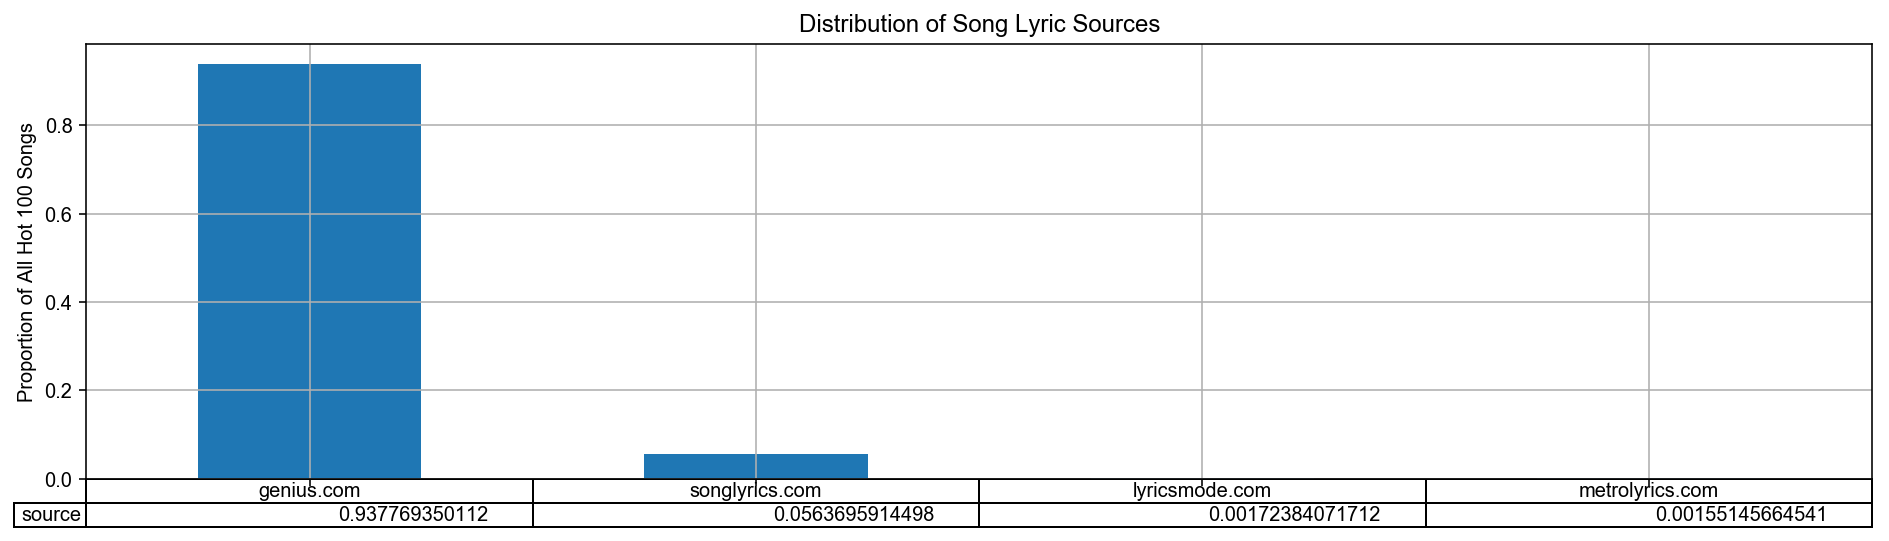

In [335]:
ax = (billboard['source'].value_counts() / len(billboard)).plot.bar(
    table=True, figsize=(16,4))
ax.grid(True)
ax.set_xticklabels([])
ax.set(ylabel='Proportion of All Hot 100 Songs',
       title='Distribution of Song Lyric Sources')

In [329]:
billboard['lyrics'].isnull().sum() / len(billboard)

0.0077572832270298223

In [255]:
url = 'https://genius.com/marvin-gaye-pride-and-joy-lyrics'
html = requests.get(url=url).content
soup = bs4.BeautifulSoup(html)
lyrics = soup.find('div', {'class': 'lyrics'}).find('p').findAll(text=True)

## Save data

In [318]:
billboard.to_csv('../data/billboard-lyrics.csv', index=False)